**Review**

Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did an excellent job overall, there's just one tiny problem that needs to be fixed before the project is accepted. It should be very straightforward though!

<div class="alert alert-info">
  Hey Dmitry, Thank you for reviewing my project! Thanks for the comments! I will respond and fix each one separately.
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>
  
You're welcome! The project is accepted. Keep up the good work in the next sprint! :)
    
P.S. Just wanted to let you know about a couple of points I forgot to mention in the first review, but that might be good to keep in mind for future projects:
  
1. As hyperparameters maximizing the model's accuracy are not necessarily the same as the hyperparameters maximizing F1 score, which is our target metric, it would be better to set the `scoring` parameter of `HalvingGridSearchCV` to `f1`. Scoring paramater even lets you use your custom metric if you need, check out [sklearn docs](https://scikit-learn.org/stable/modules/model_evaluation.html) for a nice overview.
2. Another point is that if you use cross-validation, the proper way to scale the data is not to scale the whole train set, but use a pipeline with scaler + model (check out the example at [sklearn docs page for pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)). The idea is that if you scale the whole train set, the train subset in each fold will have implicit knowledge about the validation subset in that fold, because scaler was fit on their concatenation. If you use a pipeline, then the data will be scaled for each fold of cross-validation separately: with the scaler fit using only that fold's train subset. This helps to get a less biased cross-validation score. After you create a pipeline (pretty much just `pipeline = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])`), you just use it in place of a model as an input to `GridSearchCV` and similar functions. And it works like a regular model to fit (`pipeline.fit(X_train, y_train)`) and make predictions on new data (`pipeline.predict(X_test)`)

  
</div>

# Building a Model that Predict Leaving Customers the Beta Bank

## Background:

In Beta Bank customers leave the bank slowly. At the moment, bankers are interested in trying to prevent customers leaving and therefore, by examining customer behavior so far, it is necessary to build a model that will predict whether a customer will leave the bank soon.

In order for the model to be good, it is necessary to find one with a maximum F1 score, and in any case not lower than 0.59.

In [1]:
#Import all the libraries that will be used in the project:

import sklearn
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets, metrics 

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score, f1_score, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV


from sklearn.datasets import make_classification
from sklearn.utils import shuffle


In [2]:
pip install missingno

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install fast-ml

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install --upgrade scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: scikit-learn in /home/jovyan/.local/lib/python3.7/site-packages (1.0)
Note: you may need to restart the kernel to use updated packages.


In [6]:
print(sklearn.__version__)

1.0


In [7]:
from sklearn.experimental import enable_halving_search_cv

In [8]:
import missingno as msno
import numpy as np
from fast_ml.model_development import train_valid_test_split

In [9]:
from sklearn.model_selection import HalvingGridSearchCV

## Download and prepare the data:

In [10]:
try:
    data=pd.read_csv('/datasets/Churn.csv')
except:
    data=pd.read_csv('Churn.csv')

In [11]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


### Data description:

Features:
* RowNumber - data string index
* CustomerId - unique customer identifier
* Surname - surname
* CreditScore - credit score
* Geography - country of residence
* Gender - gender
* Age - age
* Tenure - period of maturation for a customer’s fixed deposit (years)
* Balance - account balance
* NumOfProducts - number of banking products used by the customer
* HasCrCard - customer has a credit card
* IsActiveMember - customer’s activeness
* EstimatedSalary - estimated salary

Target:
* Exited - сustomer has left

### Check the data:

* Missing values
* Type of cells
* Shape, size and describe 

In [12]:
#Missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


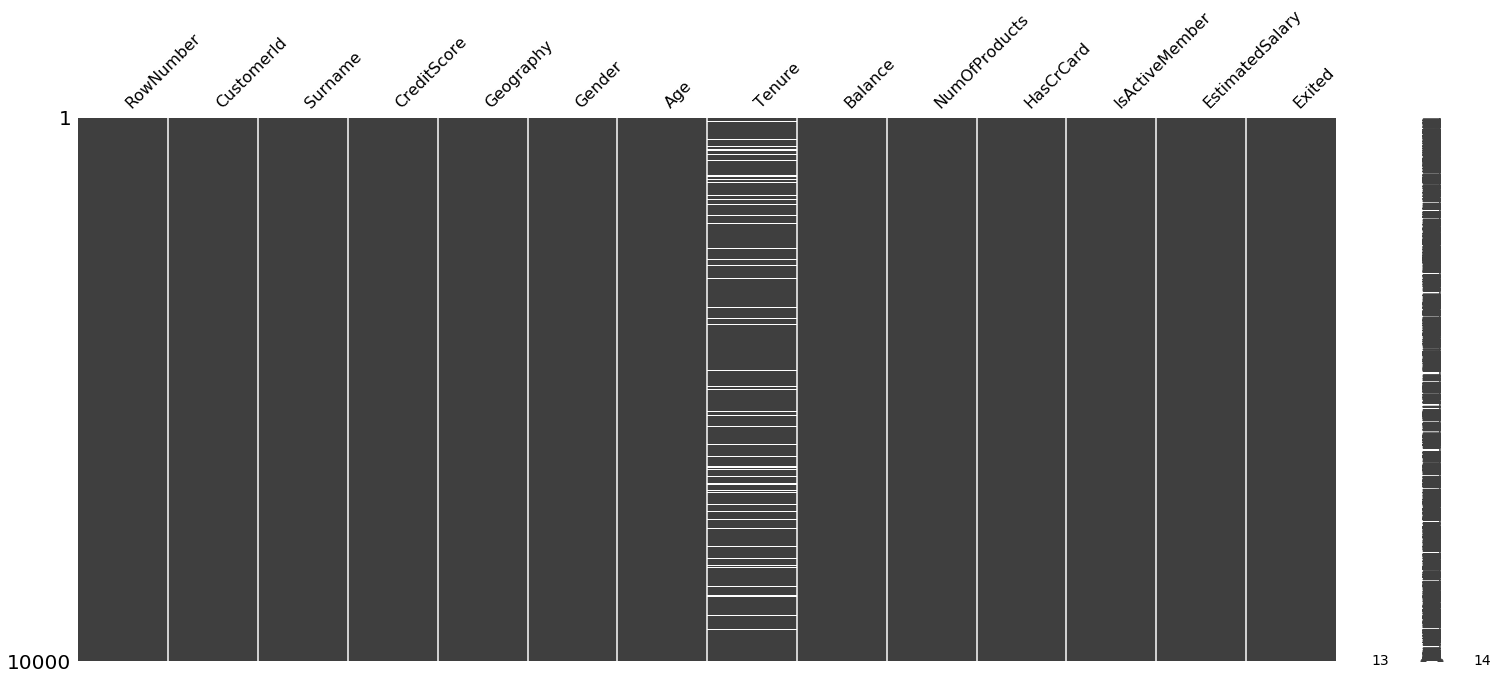

In [13]:
msno.matrix(data)
plt.show()

In [14]:
data.isnull().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [15]:
data.shape

(10000, 14)

In [16]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


#### Check the data - Conclusions and things that need to be fixed:

* There are 3 columns whose information will not be useful to the models and therefore can be removed: RowNumber, CustomerId and Surname.
* There are 909 missing values in the Tenure column, A prediction model can be builded that will predict the missing values - according to suggestion number 6 of this article: https://towardsdatascience.com/7-ways-to-handle-missing-values-in-machine-learning-1a6326adf79e
* After filling the missing values, the Tenure column type should be changed to int.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Alright, the data was loaded and inspected.

</div>

<div class="alert alert-warning">
<b>Reviewer's comment</b>

Making a model to fill missing values is a reasonable method, but in this case missing values might have a simple explanation: tenure represents how long someone has been a client, and a missing value could just mean a new client.

</div>

In [17]:
#Drop the columns than not help the models:
data=data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

<div class="alert alert-success">
<b>Reviewer's comment</b>

Makes sense!

</div>

In [18]:
#Build model that predict the missing values:

#Select the numeric columns 
numeric=data[['CreditScore', 'Gender', 'Age','Tenure', 'NumOfProducts', 'HasCrCard', 
              'IsActiveMember', 'EstimatedSalary', 'Exited']]

#Change male and female to 0 and 1 respectively 
numeric['Gender']=[1 if x=='Male' else 0 for x in data['Gender']]

#Split the numeric data into test_data (contain the missing values) and train (contain the rest of the data):
#test
test_data=numeric[numeric['Tenure'].isnull()]
x_test=test_data.drop('Tenure', axis=1)

numeric.dropna(inplace=True)

#train
x_train=numeric.drop('Tenure', axis=1)
y_train=numeric['Tenure']

#train the model
model=LinearRegression()
model.fit(x_train, y_train)

#predict the target of test
predicted_test=model.predict(x_test)

#change the predict target to array
np_array = np.array(predicted_test)

#round the values to integer
np_round_to_int = np.around(np_array, 0)
round_to_int = list(np_round_to_int)

#fill the missing values using the values that model predicted:
fill = pd.DataFrame(index=data.index[data.isnull().any(axis=1)], data=round_to_int ,columns=['Tenure'])
data=data.fillna(fill)

In [19]:
#Change the type of Tenure column to int
data['Tenure']=data['Tenure'].astype('int')

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


The data is modified and corrected as needed.

### EDA

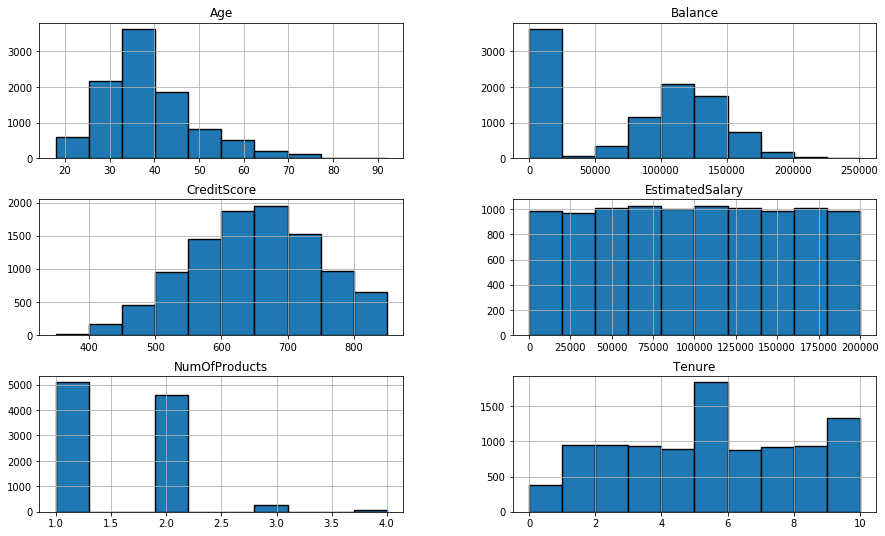

In [21]:
#Histograms for numeric features
data_numeric=data[['Age', 'Balance', 'CreditScore', 'EstimatedSalary', 'Tenure', 'NumOfProducts']]

data_numeric.hist(edgecolor='black', linewidth=1.4, figsize=(15,9));

* Age: The age is divided with a positive skew, between the ages of almost 20 and 80. When the average is higher than the median the higher the mode. Most of the bank's customers are customers in their third and fourth decade of life.
* Balance: Most customers with an account balance of up to 25K, no customers with a debtit balance, and the rest of the customers have a high credit balance of up to 200K that is distributed almost normally.
* Credit score: The customer score is divided from 400 to 800 when most customers have a reasonable score.
* Estimated salary: Customers' salaries are uniform distributed up to 200K.
* Num of products: Most customers consume one or two products.

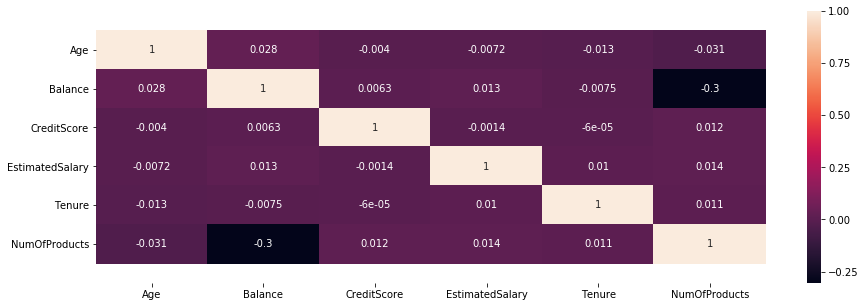

In [22]:
#Heatmap for check corrolation 
plt.figure(figsize=(15,5))
ax = sns.heatmap(data_numeric.corr(), annot=True)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);
plt.yticks(rotation=0);

There is not too much correlation between the various features, apart from the partial opposite correlation between balance and the number of bank products, the more products a customer has, the lower his balance, and vice versa.

In [23]:
#Checking whether the target variable is balanced
data.Exited.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

The target contains non-balance values and this should be taken into account when building the models.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you explored the data a bit and noted the class imbalance

</div>

### Prepare the data to build models:

* Create dummies for non-numeric columns using OHE techniq.
* Split the data to features and target.
* Splitting the data into three different features and three different targets (train 60%, valid 20%, test 20%).
* Standardize the columns with the numeric values.

In [24]:
#Create dummies for non-numeric columns using OHE techniq
data=pd.get_dummies(data, drop_first=True)

<div class="alert alert-success">
<b>Reviewer's comment</b>

Categorical features were encoded

</div>

In [25]:
#Split the data to features and target
target=data['Exited']
features=data.drop(['Exited'], axis=1)

#Splitting the data into three different features and three different targets
x_train, y_train, x_valid, y_valid, x_test, y_test = train_valid_test_split(
    data, target='Exited', train_size=0.6, valid_size=0.2, test_size=0.2, random_state=12345
)

#Save the name of numeric columns in numeric variable 
numeric=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

#Standardize the columns with the numeric values
scaler=StandardScaler()
scaler.fit(x_train[numeric])

x_train[numeric]=scaler.transform(x_train[numeric])
x_valid[numeric]=scaler.transform(x_valid[numeric])
x_test[numeric]=scaler.transform(x_test[numeric])

<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was split into train, validation and test. The proportions are reasonable. Scaling was applied correctly.

</div>

In [26]:
print('Features shape:')
print('train:', x_train.shape)
print('valid:', x_valid.shape)
print('test:', x_test.shape)

Features shape:
train: (6000, 11)
valid: (2000, 11)
test: (2000, 11)


In [27]:
print('Target shape:')
print('train:', y_train.shape)
print('valid:', y_valid.shape)
print('test:', y_test.shape)

Target shape:
train: (6000,)
valid: (2000,)
test: (2000,)


In [28]:
data.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


### Conclusion:

After learning the values in the data, EDA, and preparing the data to build models using OHE, splitting and standerize: Splitting the resulting data was according to the percentage of distribution. The problem with data is that the target is imbalance and should therefore be taken into account when building and training the models.

Now we can find the model with the highest F1_score...

## Train the model without taking into account the imbalance:

Since this data containing classification type information, three models can be used:
* RandomForestClassifier
* DecisionTreeClassifier
* LogisticRegression

The best model will be chosen by the hypermeters offered by GridSearchCV or HalvingGridSearchCV

For each model, we will evaluate its quality using classification_report which gives the recall, precision, f1 score and accuracy.

### RandomForestClassifier:

In [29]:
#RandomForestClassifier best estimator
param_grid = {'max_depth': [3, 5, 7, 9, 11], 'min_samples_split': [2, 6, 10]}
model = RandomForestClassifier(random_state=12345)
rfc = HalvingGridSearchCV(model, param_grid, cv=5, factor=2, resource='n_estimators', 
                         max_resources=30).fit(x_train, y_train)
best_score=rfc.best_estimator_
print(best_score)
print('The best score:', rfc.best_score_)

RandomForestClassifier(max_depth=9, min_samples_split=10, n_estimators=24,
                       random_state=12345)
The best score: 0.8644999999999999


In [30]:
print(classification_report(y_valid, rfc.predict(x_valid), digits=4))

              precision    recall  f1-score   support

           0     0.8693    0.9753    0.9193      1582
           1     0.8267    0.4450    0.5785       418

    accuracy                         0.8645      2000
   macro avg     0.8480    0.7102    0.7489      2000
weighted avg     0.8604    0.8645    0.8481      2000



### DecisionTreeClassifier:

In [31]:
#DecisionTreeClassifier best estimator
#Create the parameter grid based on the results of random search
param_grid = {'max_depth': [3, 5, 7, 9, 11], 'min_samples_leaf': [5, 10, 20, 50, 100], 'criterion': ["gini", "entropy"]}
model = DecisionTreeClassifier(random_state=12345)
dtc = GridSearchCV(model, param_grid=param_grid, cv=4, n_jobs=-1, verbose=1, scoring = "accuracy").fit(x_train, y_train)

best_score=dtc.best_estimator_
print(best_score)
print('The best score:', dtc.best_score_)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=20,
                       random_state=12345)
The best score: 0.8611666666666666


In [32]:
print(classification_report(y_valid, dtc.predict(x_valid), digits=4))

              precision    recall  f1-score   support

           0     0.8619    0.9665    0.9112      1582
           1     0.7655    0.4139    0.5373       418

    accuracy                         0.8510      2000
   macro avg     0.8137    0.6902    0.7242      2000
weighted avg     0.8417    0.8510    0.8331      2000



### LogisticRegression:

In [ ]:
#LogisticRegression best estimator
model = LogisticRegression() 
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solvers, penalty=penalty, C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=12345)
lr = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, 
                           scoring='accuracy',error_score=0).fit(x_train, y_train)

best_score=lr.best_estimator_
print(best_score)
print('The best score:', lr.best_score_)

In [ ]:
print(classification_report(y_valid, lr.predict(x_valid)))

### Precision-Recall (PR) Curve for the best model in each type:

In [ ]:
#Plot Precision-Recall Curve
plt.figure(figsize=(9,8))

#curve for RandomForestClassifier
probabilities_valid = rfc.predict_proba(x_valid)
precision, recall, thresholds = precision_recall_curve(y_valid, probabilities_valid[:, 1])
plt.step(recall, precision, label='RandomForestClassifier')

#curve for DecisionTreeClasifier
probabilities_valid = dtc.predict_proba(x_valid)
precision, recall, thresholds = precision_recall_curve(y_valid, probabilities_valid[:, 1])
plt.step(recall, precision, label='DecisionTreeClassifier')

#curve for LogisticRegression
probabilities_valid = lr.predict_proba(x_valid)
precision, recall, thresholds = precision_recall_curve(y_valid, probabilities_valid[:, 1])
plt.step(recall, precision, label='LogisticRegression')

#graph design
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend()

plt.show() 

The higher the PR curve, the better the model. According to the curve obtained for the three models, it can be seen that the RandomForestClassifier model with the best hyperparameter values has the highest curve, which indicates that it is the best model so far.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Precision-recall curve is a good way to learn more about the model's performance!

</div>

### ROC curve for the best model in each type:

In [ ]:
#Plot ROC curve
plt.figure(figsize=(9,8))

#curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')

#curve for RandomForestClassifier
probabilities_valid = rfc.predict_proba(x_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)
plt.plot(fpr, tpr, label='RandomForestClassifier')

#curve for DecisionTreeClasifier
probabilities_valid = dtc.predict_proba(x_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)
plt.plot(fpr, tpr, label='DecisionTreeClassifier')

#curve for LogisticRegression
probabilities_valid = lr.predict_proba(x_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)
plt.plot(fpr, tpr, label='LogisticRegression')

#graph design
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()

plt.show()

The higher the ROC curve, the better the model. According to the curve obtained for the three models, it can be seen that the RandomForestClassifier model with the best hyperparameter values has the highest curve, which indicates that it is the best model so far. At the same time, the rest of the model is still higher than the random model, which indicates that their model is still better than a random model.

### Summary F1 score and ROC AUC score for the best model in each type:

In [ ]:
scores=[
    ['RandomForestClassifier', f1_score(y_valid, rfc.predict(x_valid)), roc_auc_score(y_valid, rfc.predict_proba(x_valid)[:, 1]), accuracy_score(y_valid, rfc.predict(x_valid))], 
    ['DecisionTreeClassifier', f1_score(y_valid, dtc.predict(x_valid)), roc_auc_score(y_valid, dtc.predict_proba(x_valid)[:, 1]), accuracy_score(y_valid, dtc.predict(x_valid))], 
    ['LogisticRegression', f1_score(y_valid, lr.predict(x_valid)), roc_auc_score(y_valid, lr.predict_proba(x_valid)[:, 1]), accuracy_score(y_valid, lr.predict(x_valid))]
]

In [ ]:
sum_score=pd.DataFrame(scores, columns = ['Model', 'F1_score', 'ROC_auc_score', 'Accuracy_score'])
sum_score

In the sum_score table you can see the f1_score and roc_auc_score values for each of the models with the best hyperparameter values. The highest score was obtained for RandomForestClassifier. However, since the data is imbalance and although this model received the highest score, the score is not sufficient to use this model. It is necessary to continue to optimize the best model in order to match the type of data obtained.

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

Very good, you evaluated all models using both F1 score and ROC-AUC. There's a small problem though: to calculate ROC-AUC you need to use probabilities (method `predict_proba`) like you did to plot the ROC curve above, not just binary predictions (method `predict`).

</div>

<div class="alert alert-info">
  Thanks, my mistake 😬, I fixed it.
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>
  
Great!
  
</div>

### Sanity check the model:

In [ ]:
data.Exited.value_counts(normalize=True)

In [ ]:
target_predict_constant=pd.Series([0 for x in range(len(y_valid.index))])
print('Accuracy for constant model:', accuracy_score(y_valid, target_predict_constant))
print('F1 score:', f1_score(y_valid, target_predict_constant))
print('ROC-AUC score:', roc_auc_score(y_valid, target_predict_constant))

Just to make sure that the models we have created so far are better than a constant model, we did a sanity check whose accuracy is lower than the accuracy of the other models and therefore, our models are better than a constant model. In addition, in the constant model, f1 is equal to 0 and roc_auc indicates that the predictions have no meaning.

<div class="alert alert-warning">
<b>Reviewer's comment</b>

That's a good point, but as our target metrics are F1 score and ROC-AUC, it would make sense to evaluate the constant model using those too.

</div>

<div class="alert alert-info">
  Make sense! I added these metrics.
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>
  
Cool!
  
</div>

## Improve the quality of the model:

Improve the quality of the model. Make sure you use at least two approaches to fixing class imbalance. Use the training set to pick the best parameters. Train different models on training and validation sets. Find the best one. Briefly describe your findings

Since we have seen that the data is imbalance this is why the score we have received so far is relatively low. To improve the model, we will use two techniques that are suitable for imbalance:
* Upsampling (Double the features_ones 4 times so that it is equal in size to features_zeros)
* Downsampling (Set fraction equal to 0.25 in order for features_ones to be equal in size to features_zeros)

After examining these techniques and finding the technique that most enhances the model, we will use another technique to see if the model can be further improved. The other technique is Threshold.


### Upsampling:

Upsampling function that get features, targe and number of repeat, and after split the data to negative and positive observations, repeat the positive observations, create new sample training and shuffle the data, the function return features and target upsampling on which the desired model can be applied.

In [ ]:
#Upsampling function
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

#### Upsampling for RandomForestClassifier:

In [ ]:
#Apply the upsampling function
features_upsampled, target_upsampled = upsample(x_train, y_train, 4)

model=RandomForestClassifier(max_depth=9, n_estimators=24, min_samples_split=6, random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid=model.predict(x_valid)

print('F1 for RandomForestClassifier:', f1_score(y_valid, predicted_valid))

#### Upsampling for DecisionTreeClassifier:

In [ ]:
features_upsampled, target_upsampled = upsample(x_train, y_train, 4)

model=DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=20, random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid=model.predict(x_valid)

print('F1 for DecisionTreeClassifier:', f1_score(y_valid, predicted_valid))

#### Upsampling for LogisticRegression:

In [ ]:
features_upsampled, target_upsampled = upsample(x_train, y_train, 4)

model=LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid=model.predict(x_valid)

print('F1 for LogisticRegression:', f1_score(y_valid, predicted_valid))

All F1 score values obtained after Upsampling were higher than the models before the Upsampling technique was applied to them. In first place is the RandomStateClasiffier model.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Upsampling function is correct, it was applied only to the train set, and the repeat value is reasonable

</div>

### Downsampling:

In a function that uses the Downsampling technique, the function gets the feature and target values as well as the fraction of the amount of data we want to leave, then splits the training sample into positive and negative observations, then randomly removes some of the negative observations, creates a new trainig sample based on the data all to make sure the positive data is not tracked.

In [ ]:
#Downsample function
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

#### Downsampling for RandomForestClassifier:

In [ ]:
features_downsampled, target_downsampled = downsample(x_train, y_train, 0.25)

model=RandomForestClassifier(max_depth=9, n_estimators=24, min_samples_split=6, random_state=12345) 
model.fit(features_downsampled, target_downsampled)
predicted_valid=model.predict(x_valid)

print('F1:', f1_score(y_valid, predicted_valid))

#### Downsampling for DecisionTreeClassifier:

In [ ]:
features_downsampled, target_downsampled = downsample(x_train, y_train, 0.25)

model=DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=20, random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid=model.predict(x_valid)

print('F1:', f1_score(y_valid, predicted_valid))

#### Downsampling for LogisticRegression:

In [ ]:
features_downsampled, target_downsampled = downsample(x_train, y_train, 0.25)

model=LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid=model.predict(x_valid)

print('F1:', f1_score(y_valid, predicted_valid))

All F1 score values obtained after Downsampling were higher than the models before the Downsampling technique was applied to them. In first place is the RandomStateClasiffier model, but still the score obtained is lower than the score obtained for the Upsampling technique. This is because usually a lower amount of data will ultimately result in less good model quality.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Downsampling was done correctly as well

</div>

### Threshold:

Now, the model options have narrowed down, we will choose the RandomForestClasiffier model with the hyperparameters that have been proven to make the model better, along with running the Upsampling technique and we will test the Threshold technique on it, we will check which Threshold values will give us the highest F1 score.

In [ ]:
#The best model so far:
features_upsampled, target_upsampled = upsample(x_train, y_train, 4)

model=RandomForestClassifier(max_depth=9, n_estimators=24, min_samples_split=6, random_state=12345)
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(x_valid)
probabilities_one_valid = probabilities_valid[:, 1]

In [ ]:
#Loop for check which value of threshold return the best F1 score
for threshold in np.arange(0.5, 0.6, 0.01):
    predicted_valid = (probabilities_one_valid > threshold).astype(int)  
    precision = precision_score(y_valid, predicted_valid) 
    recall = recall_score(y_valid, predicted_valid) 
    f1=f1_score(y_valid, predicted_valid)
    accuracy=accuracy_score(y_valid, predicted_valid)
    roc_auc=roc_auc_score(y_valid, predicted_valid)
    print('Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}, F1={:.3f}, Accuracy = {:.3f}, roc_auc = {:.3f}'.format(threshold, precision, recall, f1, accuracy, roc_auc))

It can be seen that the highest F1 score value is obtained when Threshold is equal to 0.55, which means that this technique helped us to improve the quality of the model in terms of F1 score.

**Characteristics of the best model:**
* RandomForestClassifier(max_depth=9, n_estimators=24, min_samples_split=6, random_state=12345)
* Upsampling techniq with 4 repeats
* Threshold techniq equals 4

<div class="alert alert-success">
<b>Reviewer's comment</b>

Yep, tuning the threshold is a good way to get a better F1 score!

</div>

### Precision-Recall (PR) Curve for the best model and previous best model:

In [ ]:
#Plot Precision-Recall Curve
plt.figure(figsize=(9,8))

#curve for RandomForestClassifier
features_upsampled, target_upsampled = upsample(x_train, y_train, 4)

model=RandomForestClassifier(max_depth=9, n_estimators=24, min_samples_split=6, random_state=12345)
model.fit(features_upsampled, target_upsampled)

probabilities_valid = model.predict_proba(x_valid)
precision, recall, thresholds = precision_recall_curve(y_valid, probabilities_valid[:, 1])
plt.step(recall, precision, label='RandomForestClassifier-the best model')

#curve for  the previous RandomForestClassifier
probabilities_valid = dtc.predict_proba(x_valid)
precision, recall, thresholds = precision_recall_curve(y_valid, probabilities_valid[:, 1])
plt.step(recall, precision, label='DecisionTreeClassifier-the previous model')


#graph design
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend()

plt.show() 

According to the graph, by applying threshold and upsampling techniques we were able to slightly improve the quality of the model.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, the plot shows clear improvement!

</div>

## Perform the final testing:

In [ ]:
features_upsampled, target_upsampled = upsample(x_train, y_train, 4)

model=RandomForestClassifier(max_depth=9, n_estimators=24, min_samples_split=6, random_state=12345)
model.fit(features_upsampled, target_upsampled)

probabilities_test = model.predict_proba(x_test)
probabilities_train = model.predict_proba(x_train)

probabilities_one_test = probabilities_test[:, 1]
probabilities_one_train = probabilities_train[:, 1]

In [ ]:
threshold=0.55
predicted_test = (probabilities_one_test > threshold).astype(int)
predicted_train = (probabilities_one_train > threshold).astype(int)

precision1 = precision_score(y_train, predicted_train)
precision = precision_score(y_test, predicted_test)

recall1 = recall_score(y_train, predicted_train)
recall = recall_score(y_test, predicted_test)

f11=f1_score(y_train, predicted_train)
f1=f1_score(y_test, predicted_test)

accuracy1=accuracy_score(y_train, predicted_train)
accuracy=accuracy_score(y_test, predicted_test)

roc_auc1=roc_auc_score(y_train, model.predict_proba(x_train)[:, 1])
roc_auc=roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])

print('Training set: ')
print('Precision = {:.3f}, Recall = {:.3f}, F1={:.3f}, Accuracy = {:.3f}, roc_auc = {:.3f}'.format(precision1, recall1, f11, accuracy1, roc_auc1))
print()
print('Test set: ')
print('Precision = {:.3f}, Recall = {:.3f}, F1={:.3f}, Accuracy = {:.3f}, roc_auc = {:.3f}'.format(precision, recall, f1, accuracy, roc_auc))

We got in test set, F1 score is slightly lower than the value obtained in the valid set, but still has a high score and meets the required conditions.

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

Same problem as above with ROC-AUC score calculation. Also the train set scores are calculated using targets as predictions

</div>

<div class="alert alert-info">
   I fixed again.
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>
  
Good!
  
</div>

## Conclusion:

In this project we were asked to build a model that would predict the likelihood of customers leaving soon. The data on which the model had to be built is data on the bank's past customers, customer details, their banking behavior and whether they left or stayed at the bank.

Since this is a classification type data, we built three appropriate models and tested the hyperparameters that affect the quality of the model. At first we did not address the fact that data is imbalance and we built models without taking this detail into account. 

The quality of the models obtained was reasonable but still not enough to use them as quality models.
Therefore, in the next step we improved the model with respect to it being imbalance, the model was improved using an upsampling technique when we doubled the positive values 4 times in order to reach the number of negative values, and changed the threshold value to the value that gave the best quality to threshold = 0.55.

The best model obtained is:
* RandomForestClassifier(max_depth=9, n_estimators=24, min_samples_split=6, random_state=12345)
* Upsampling techniq with 4 repeats
* Threshold techniq equals 4

And from the test set test these are the values obtained: Precision = 0.593, Recall = 0.631, F1=0.612, Accuracy = 0.831, roc_auc = 0.854

<div class="alert alert-success">
<b>Reviewer's comment</b>

Nice summary!

</div>